In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from mpl_toolkits.mplot3d import Axes3D

from helper_file import ROOT_PATH

Root Folder location: /workspaces/MultiClass_Pump_Prediction


## Read Data

In [26]:
pump_data = pd.read_csv(f"{ROOT_PATH}/data/processed/cleaned.csv", index_col=0)
pump_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56064 entries, 69572 to 26348
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   amount_tsh              56064 non-null  float64
 1   gps_height              56064 non-null  int64  
 2   longitude               56064 non-null  float64
 3   latitude                56064 non-null  float64
 4   num_private             56064 non-null  int64  
 5   basin                   56064 non-null  object 
 6   district_code           56064 non-null  int64  
 7   population              56064 non-null  int64  
 8   public_meeting          56064 non-null  bool   
 9   funder_combined         56064 non-null  object 
 10  installer_combined      56064 non-null  object 
 11  wpt_name_combined       56064 non-null  object 
 12  subvillage_combined     56064 non-null  object 
 13  region_combined         56064 non-null  object 
 14  lga_combined            56064 non-null 

## Correlation Analysis

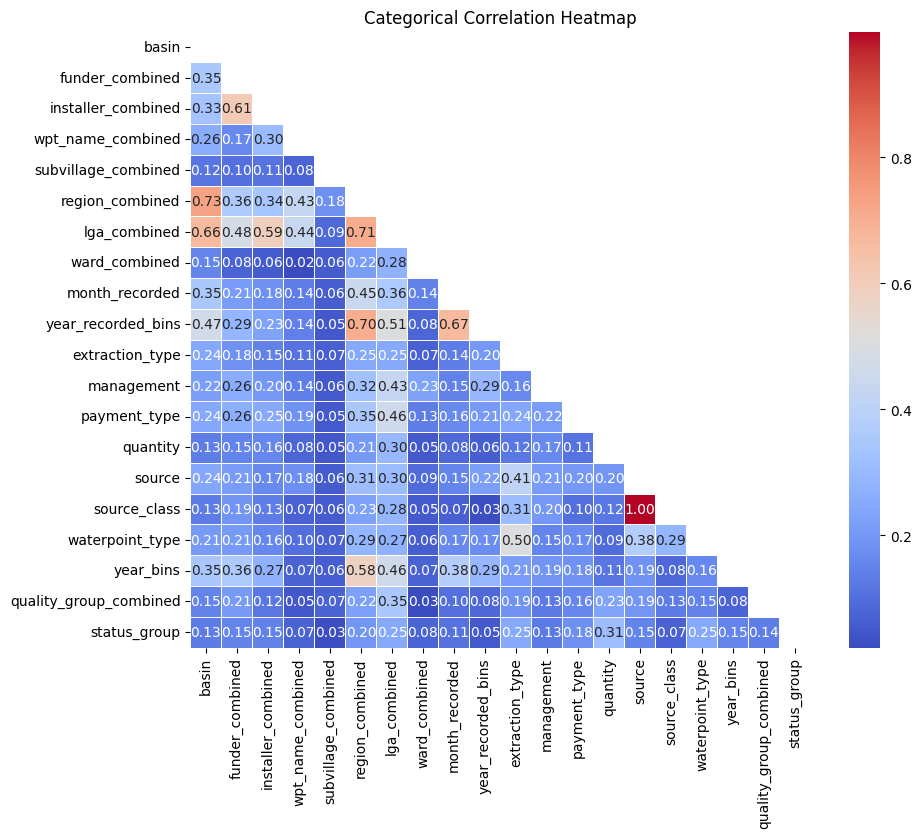

In [27]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

def categorical_correlation_heatmap(data):
    # Calculate Cramér's V correlation matrix
    cat_cols = data.select_dtypes(include=['object']).columns
    corr_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
    for col1 in cat_cols:
        for col2 in cat_cols:
            corr_matrix.loc[col1, col2] = cramers_v(data[col1], data[col2])

    # Plot the correlation heatmap
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
    plt.title("Categorical Correlation Heatmap")
    plt.show()

categorical_correlation_heatmap(pump_data)

As observed we have certain columns with high correlation. We will remove all the columns with correlation coefficient greater than equal to `0.7`

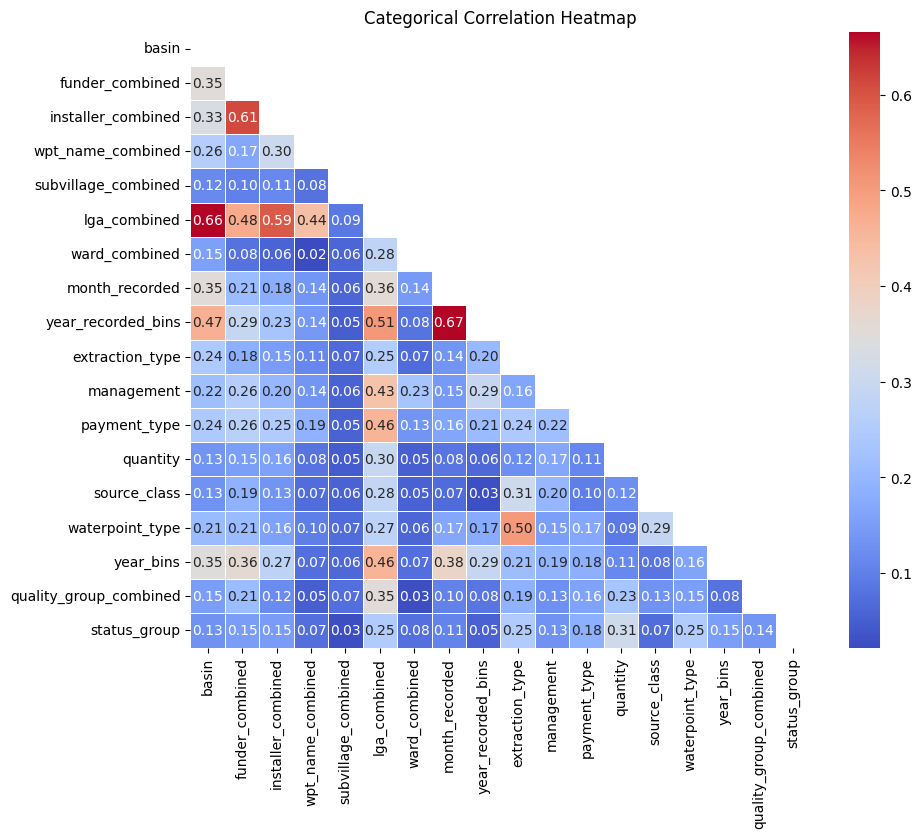

In [28]:
correlation_drop_cols = ['region_combined', 'source']
filtered_pump_data = pump_data.drop(correlation_drop_cols, axis=1)
categorical_correlation_heatmap(filtered_pump_data)

### Correlation for numerical columns

<Axes: >

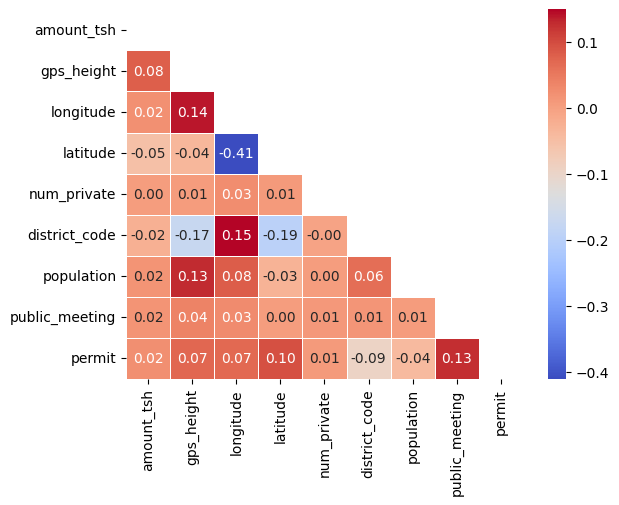

In [29]:
num_cols = pump_data.select_dtypes(include=['float64', 'int64', 'bool']).columns
corr_data = pump_data.loc[:,num_cols].corr()
mask = np.triu(np.ones_like(corr_data, dtype=bool))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)

No significant correlation found

## One Hot Encoding

In [30]:
def one_hot_encode_categorical(data):

    transformer = ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse_output=False), selector(dtype_include=object))],
                                    remainder='passthrough')
    encoded_data = transformer.fit_transform(data)
    return pd.DataFrame(encoded_data, columns=transformer.get_feature_names_out())

def perform_pca(data, num_components=None):
    
    id_col = data.index
    pca = PCA(n_components=num_components)
    pca_data = pca.fit_transform(data)
    variance_explained = sum(pca.explained_variance_ratio_)
    pca_data = pd.DataFrame(pca_data, columns=["Component_"+str(i) for i in range(1, pca_data.shape[1]+1)])
    pca_data["id"] = id_col
    return pca_data, variance_explained

def plot_variance_explained(variance_explained_list):
    
    plt.figure(figsize=(10, 5))
    num_components = list(range(1, len(variance_explained_list) + 1))
    plt.plot(num_components, variance_explained_list, marker='o')
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Variance Explained')
    plt.title('Variance Explained by PCA Components')
    plt.show()

In [8]:
# Define features and target value
X = filtered_pump_data.drop(['status_group'], axis=1)
y = filtered_pump_data['status_group']

# Step 1: One-hot encoding
one_hot_encoded_data = one_hot_encode_categorical(X)

# Step 2: Plot variance explained with different numbers of PCA components
variance_explained_list = []
for n_components in range(1, one_hot_encoded_data.shape[1] + 1):
    _, variance_explained = perform_pca(one_hot_encoded_data, num_components=n_components)
    if (n_components % 15)==0 or (n_components < 5):
        print(f"Number of Components: {n_components}; Variance Explained: {variance_explained}")
    variance_explained_list.append(variance_explained)

Number of Components: 1; Variance Explained: 0.9301784109532554
Number of Components: 2; Variance Explained: 0.9782478380363948
Number of Components: 3; Variance Explained: 0.9999700838951462
Number of Components: 4; Variance Explained: 0.9999856812169571
Number of Components: 15; Variance Explained: 0.9999994734688377
Number of Components: 30; Variance Explained: 0.9999997243925267
Number of Components: 45; Variance Explained: 0.9999998417939546
Number of Components: 60; Variance Explained: 0.9999999015141773
Number of Components: 75; Variance Explained: 0.9999999364181065
Number of Components: 90; Variance Explained: 0.9999999595268434
Number of Components: 105; Variance Explained: 0.999999975133182
Number of Components: 120; Variance Explained: 0.9999999865134137
Number of Components: 135; Variance Explained: 0.9999999943894103
Number of Components: 150; Variance Explained: 0.9999999987516938
Number of Components: 165; Variance Explained: 0.9999999999999991
Number of Components: 180

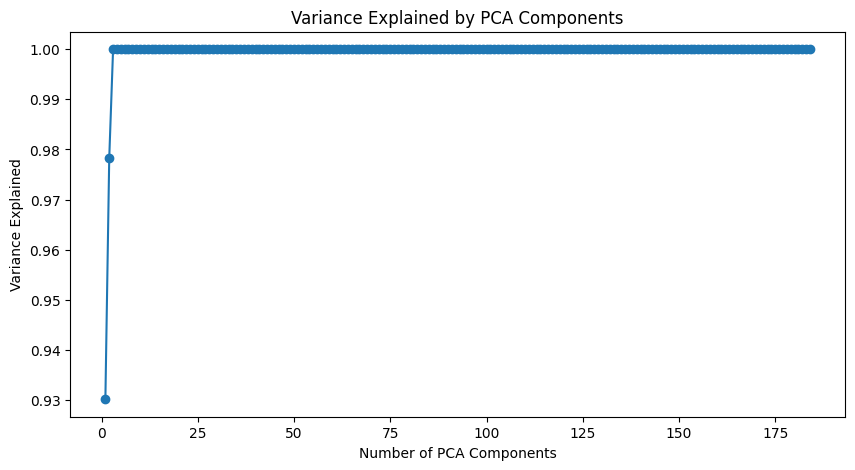

In [16]:
plot_variance_explained(variance_explained_list)

As observed that two components can explain `97.8%` of the variance in the dataset. Therefore, we can create two components and carry on our analysis.

In [39]:
pca_data, _ = perform_pca(one_hot_encoded_data, num_components=3)

In [40]:
y

id
69572        functional
34310        functional
67743    non functional
19728        functional
9944         functional
              ...      
60739        functional
27263        functional
37057        functional
31282        functional
26348        functional
Name: status_group, Length: 56064, dtype: object

In [41]:
pca_data_labels = pd.merge(pca_data, y, on="id")
pca_data_labels.drop(['id'], axis=1, inplace=True)
pca_data_labels

,Component_1,Component_2,Component_3,status_group
0,-306.499408,-34.053922,67.312780,functional
1,-340.038992,413.718581,-54.665474,functional
2,-345.181928,682.423136,-70.126714,functional
3,-325.183002,682.651592,-69.110108,non functional
4,-345.181918,682.424857,-70.120398,functional
...,...,...,...,...
42376,-312.222427,-1034.228339,-195.499791,functional
42377,-345.181783,682.421622,-70.121990,functional
42378,161.626339,331.374628,-38.010532,non functional
42379,-311.878897,-531.607758,-139.644432,functional


In [44]:
pca_data_labels.status_group.value_counts(dropna=False)

status_group
functional                 23109
non functional             16121
functional needs repair     3151
Name: count, dtype: int64

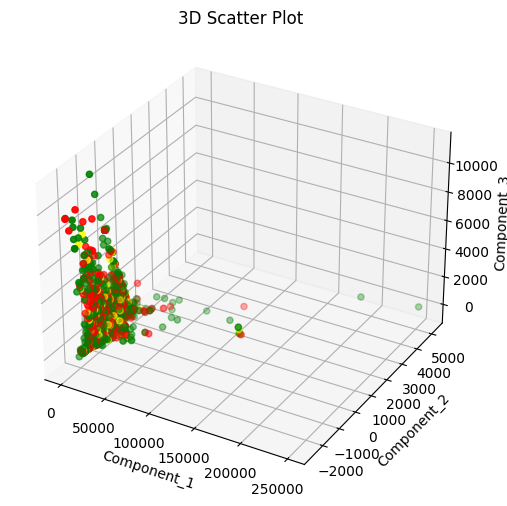

In [46]:
# Create 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
colors = {'functional': 'green', 'non functional': 'red', 'functional needs repair': 'yellow'}

# Scatter plot
ax.scatter(pca_data_labels['Component_1'], pca_data_labels['Component_2'], pca_data_labels['Component_3'],
                 marker='o', c=pca_data_labels['status_group'].map(colors))

ax.set_xlabel('Component_1')
ax.set_ylabel('Component_2')
ax.set_zlabel('Component_3')
ax.set_title('3D Scatter Plot')

# Show the plot
plt.show()